The whole notebook takes around **2 minutes** to complete on a machine with Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz.

In [1]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats import multitest
from tqdm import tqdm

import peca

In [2]:
def preprocess(df, loc):
    output = df.copy()
    output = np.log2(output + 1)
    output = output - output.rolling(window=30).mean()
    output = output.loc[loc].values
    return output

# Terrorist attacks

In [3]:
date_range = pd.date_range("2015-01-01", "2017-12-31", freq="1D")

In [4]:
# Please download GTD from https://www.start.umd.edu/gtd/ and set
# the correct path below. We use the 2014-2017 data set.
gtd_path = "/home/erik/Documents/data/globalterrorism-start/"
gtd = pd.read_csv(gtd_path + "gtd_14to17_0718dist.csv", low_memory=False)
gtd = gtd.join(pd.to_datetime(gtd[["iyear", "imonth", "iday"]].rename(
        {"iyear": "year", "imonth": "month", "iday": "day"},
        axis="columns")).rename("date"))  # create custom date column

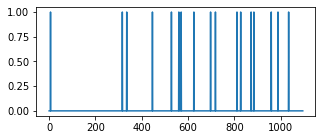

WENA-10: 17 days with events. (Several entries at the same day are viewed as a single event.)

0 2015-01-07 Paris France 12.0 12.0
1 2015-11-13 Saint Denis France 34.0 2.0
2 2015-11-13 Paris France 26.0 15.0
3 2015-11-13 Saint Denis France 34.0 1.0
4 2015-11-13 Paris France 24.0 5.0
5 2015-11-13 Paris France 26.0 19.0
6 2015-11-13 Paris France 18.0 1.0
7 2015-11-13 Paris France 217.0 93.0
8 2015-11-13 Saint Denis France 34.0 1.0
9 2015-12-02 San Bernardino United States 17.0 16.0
10 2016-03-22 Zaventem Belgium 135.0 18.0
11 2016-03-22 Brussels Belgium 135.0 17.0
12 2016-06-12 Orlando United States 53.0 50.0
13 2016-07-14 Nice France 433.0 87.0
14 2016-07-24 Ansbach Germany 15.0 1.0
15 2016-09-17 New York City United States 29.0 0.0
16 2016-09-17 St. Cloud United States 10.0 1.0
17 2016-11-28 Columbus United States 11.0 1.0
18 2016-12-19 Berlin Germany 48.0 12.0
19 2017-03-22 London United Kingdom 50.0 6.0
20 2017-04-07 Stockholm Sweden 14.0 5.0
21 2017-05-22 Manchester United Kingdom 1

In [5]:
cols = ["date", "country_txt", "city", "nkill", "nwound", "gname"]

sel_islamist = (
    (gtd["gname"] == "Al-Qaida in the Arabian Peninsula (AQAP)")
    | (gtd["gname"] == "Islamic State of Iraq and the Levant (ISIL)")
    | (gtd["gname"] == "Jihadi-inspired extremists")
    | (gtd["gname"] == "Muslim extremists"))
sel_wena = (
    (gtd["region_txt"] == "Western Europe")
    | (gtd["region_txt"] == "North America"))
sel_min10wound = (gtd["nwound"] >= 10)
sel_all = (sel_wena & sel_islamist & sel_min10wound)

index = gtd.loc[sel_all][cols].groupby("date").sum().index.copy()
eventseries = pd.Series(index=index, data=([1] * len(index)),
                        name="GTD").reindex(date_range).fillna(0).values
n_events = eventseries.sum()

plt.figure(figsize=(5, 2))
plt.plot(eventseries)
plt.show()

print(f"WENA-10: {eventseries.sum():.0f} days with events. "
      "(Several entries at the same day are viewed as a single event.)")
print()
for i, r in enumerate(gtd[sel_all].itertuples()):
    print(i, r.date.date(), r.city, r.country_txt, r.nwound, r.nkill)

# Twitter volume

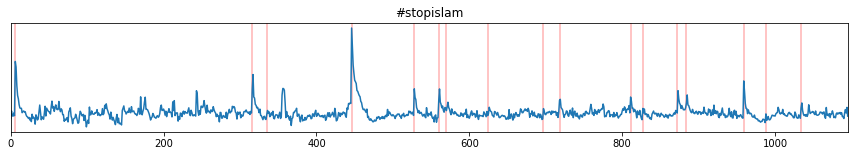

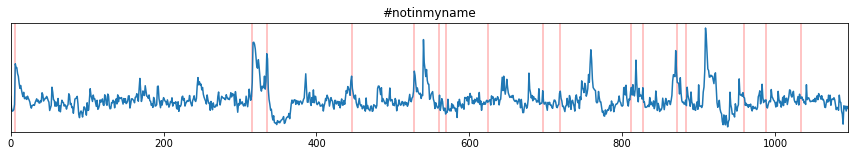

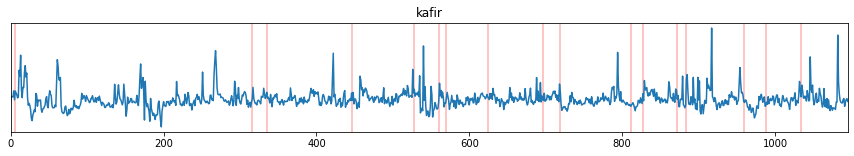

In [6]:
timeseries_df = pd.read_csv("data/twitter-volume.csv",
                            index_col=0, parse_dates=[0])
keywords = timeseries_df.columns
for keyword in keywords:
    timeseries = preprocess(timeseries_df[keyword], date_range)
    plt.figure(figsize=(15, 2))
    plt.title(keyword)
    for event in np.where(eventseries == 1)[0]:
        plt.axvline(event, color="red", alpha=0.3)
    plt.plot(timeseries)
    plt.xlim(0, len(timeseries)-1)
    plt.yticks([])
    plt.show()

# Analyses

In [7]:
delta = 7

## Section 4.3. Examples.

#### Test whether Islamist terrorist attacks systematically trigger bursts of more than 1,000 posts per day on Twitter that contain the hashtag #stopislam.

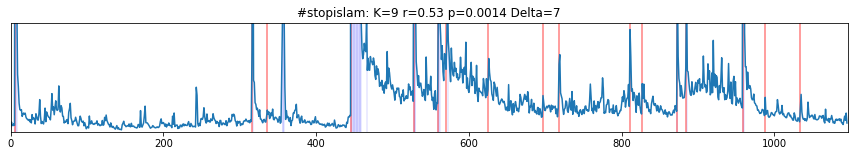

In [8]:
# NOTE: the raw time series used in this example is not stationary

keyword = "#stopislam"
timeseries = timeseries_df[keyword].loc[date_range].values
thresh = 1000
taus = np.array([thresh])

tcp_ = peca.tcp(timeseries, eventseries, delta, taus)
tcp_params = peca.tcp_params_fit(timeseries, delta, taus)
pval = peca.tcp_marginal_pval(tcp_, n_events, tcp_params)

plt.figure(figsize=(15, 2))
plt.title(f"{keyword}: "
          f"K={tcp_[0]:.0f} "
          f"r={(tcp_[0]/n_events):.2f} "
          f"p={pval[0]:.4f} Delta={delta:.0f}")
for exceedance in np.where(timeseries > thresh)[0]:
    plt.axvline(exceedance, color="blue", alpha=0.1)
for event in np.where(eventseries == 1)[0]:
    plt.axvline(event, color="red", alpha=0.5)
plt.plot(timeseries)
plt.xlim(0, len(timeseries))
plt.yticks([])
plt.ylim((0, thresh))
plt.show()

#### Test the hypothesis that Islamist terrorist attacks systematically trigger bursts of #notinmyname usage that exceed the volume of 95% of all days.

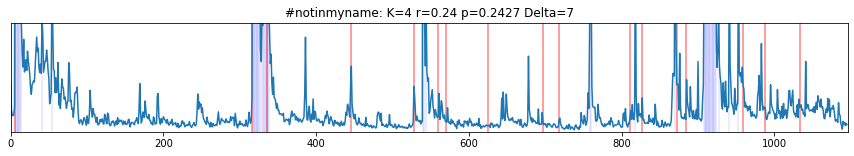

In [9]:
# NOTE: the raw time series used in this example is not stationary

keyword = "#notinmyname"
timeseries = timeseries_df[keyword].loc[date_range].values
thresh = np.percentile(timeseries, 95)
taus = np.array([thresh])

tcp_ = peca.tcp(timeseries, eventseries, delta, taus)
tcp_params = peca.tcp_params_fit(timeseries, delta, taus)
pval = peca.tcp_marginal_pval(tcp_, n_events, tcp_params)

plt.figure(figsize=(15, 2))
plt.title(f"{keyword}: "
          f"K={tcp_[0]:.0f} "
          f"r={(tcp_[0]/n_events):.2f} "
          f"p={pval[0]:.4f} Delta={delta:.0f}")
for exceedance in np.where(timeseries > thresh)[0]:
    plt.axvline(exceedance, color="blue", alpha=0.1)
for event in np.where(eventseries == 1)[0]:
    plt.axvline(event, color="red", alpha=0.5)
plt.plot(timeseries)
plt.xlim(0, len(timeseries))
plt.yticks([])
plt.ylim((0, thresh))
plt.show()

# Section 5

In [10]:
rhos = np.linspace(0.75, 1, 32)
delta = 7
simuls = 10000
alpha = 0.05

3it [01:20, 26.88s/it]


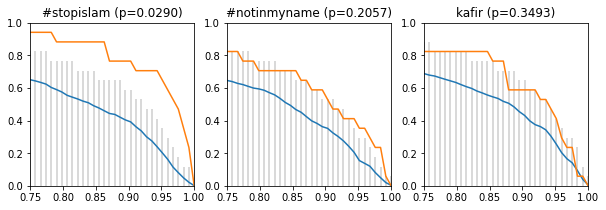

In [11]:
plt.figure(figsize=(10, 3))
for i, keyword in tqdm(enumerate(keywords)):
    timeseries = preprocess(timeseries_df[keyword], date_range)
    taus = np.percentile(timeseries, rhos * 100)
    tcp_params = peca.tcp_params_fit(timeseries, delta, taus)
    tcp_ = peca.tcp(timeseries, eventseries, delta, taus)
    pval, _ = peca.tcp_nll_pval_shuffle(timeseries, eventseries,
                                        delta, taus, simuls)

    plt.subplot(1, 3, i + 1)
    plt.plot(rhos, peca.tcp_marginal_expectation(
        n_events, tcp_params) / n_events)
    plt.vlines(rhos, np.zeros_like(rhos),
               stats.binom.ppf(1 - alpha, n_events,
                               tcp_params[0]) / n_events, alpha=0.2)
    plt.plot(rhos, tcp_ / n_events)
    plt.xlim((rhos[0], rhos[-1]))
    plt.ylim((0, 1))
    plt.title(f"{keyword} (p{('=' if pval > 0.0001 else '<')}"
              f"{(pval if pval > 0.0001 else 0.0001):.4f})")
plt.show()

#### Alternative: Multiple hypothesis testing approach with pointwise $p$-values

In [12]:
for i, keyword in enumerate(keywords):
    timeseries = preprocess(timeseries_df[keyword], date_range)
    taus = np.percentile(timeseries, rhos * 100)
    tcp_params = peca.tcp_params_fit(timeseries, delta, taus)

    tcp_ = peca.tcp(timeseries, eventseries, delta, taus)
    pvals = peca.tcp_marginal_pval(tcp_, n_events, tcp_params)

    print(keyword)
    for method in ["b", "s", "hs", "h"]:
        reject, pvals_adj, _, _ = multitest.multipletests(
            pvals, alpha=alpha, method=method)
        print("\t", method, "\t",
              "reject" if reject.any() else "no reject",
              "(p=%.4f)" % pvals_adj.min())

#stopislam
	 b 	 reject (p=0.0007)
	 s 	 reject (p=0.0007)
	 hs 	 reject (p=0.0007)
	 h 	 reject (p=0.0007)
#notinmyname
	 b 	 no reject (p=0.2754)
	 s 	 no reject (p=0.2417)
	 hs 	 no reject (p=0.2417)
	 h 	 no reject (p=0.2754)
kafir
	 b 	 no reject (p=0.6706)
	 s 	 no reject (p=0.4922)
	 hs 	 no reject (p=0.4922)
	 h 	 no reject (p=0.6706)
